In [ ]:
import polars as pl
import matplotlib.pyplot as plt

with open("jive.txt", "r") as f:
    data = [[value.strip() for value in line.split(',')] for line in f]

df = pl.DataFrame(data, schema=['yob', 'sob', 'qob', 'educ', 'lwage'], orient="row")

df = df.slice(1).with_columns(pl.all().cast(pl.Float64))

In [2]:
df = df.with_columns(
    (90 - pl.col("yob")).alias("age"),
    pl.col('lwage').exp().alias('wage')
)

print(df)

shape: (329_509, 7)
┌──────┬──────┬─────┬──────┬──────────┬──────┬────────────┐
│ yob  ┆ sob  ┆ qob ┆ educ ┆ lwage    ┆ age  ┆ wage       │
│ ---  ┆ ---  ┆ --- ┆ ---  ┆ ---      ┆ ---  ┆ ---        │
│ f64  ┆ f64  ┆ f64 ┆ f64  ┆ f64      ┆ f64  ┆ f64        │
╞══════╪══════╪═════╪══════╪══════════╪══════╪════════════╡
│ 30.0 ┆ 45.0 ┆ 1.0 ┆ 12.0 ┆ 5.790019 ┆ 60.0 ┆ 327.019238 │
│ 30.0 ┆ 45.0 ┆ 1.0 ┆ 11.0 ┆ 5.952494 ┆ 60.0 ┆ 384.711614 │
│ 30.0 ┆ 45.0 ┆ 1.0 ┆ 12.0 ┆ 5.315949 ┆ 60.0 ┆ 203.557598 │
│ 30.0 ┆ 45.0 ┆ 1.0 ┆ 12.0 ┆ 5.595926 ┆ 60.0 ┆ 269.326931 │
│ 30.0 ┆ 37.0 ┆ 1.0 ┆ 12.0 ┆ 6.068915 ┆ 60.0 ┆ 432.211478 │
│ …    ┆ …    ┆ …   ┆ …    ┆ …        ┆ …    ┆ …          │
│ 39.0 ┆ 9.0  ┆ 4.0 ┆ 16.0 ┆ 6.32398  ┆ 51.0 ┆ 557.788579 │
│ 39.0 ┆ 34.0 ┆ 4.0 ┆ 15.0 ┆ 5.847161 ┆ 51.0 ┆ 346.24998  │
│ 39.0 ┆ 34.0 ┆ 4.0 ┆ 12.0 ┆ 5.909597 ┆ 51.0 ┆ 368.557597 │
│ 39.0 ┆ 25.0 ┆ 4.0 ┆ 5.0  ┆ 6.047781 ┆ 51.0 ┆ 423.172967 │
│ 39.0 ┆ 36.0 ┆ 4.0 ┆ 19.0 ┆ 5.766817 ┆ 51.0 ┆ 319.519083 │
└──────┴──────┴─────

In [3]:
mean_age = df['age'].mean()
std_age = df['age'].std()
mean_wage = df['wage'].mean()
std_wage = df['wage'].std()

print(f"Mean age: {mean_age:.2f}, Std age: {std_age:.2f}")
print(f"Mean wage: {mean_wage:.2f}, Std wage: {std_wage:.2f}")

Mean age: 55.40, Std age: 2.90
Mean wage: 439.47, Std wage: 364.94


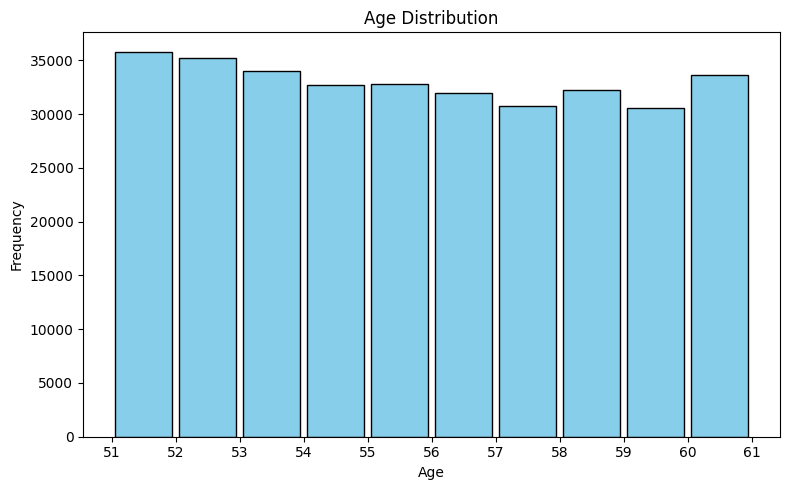

<Figure size 640x480 with 0 Axes>

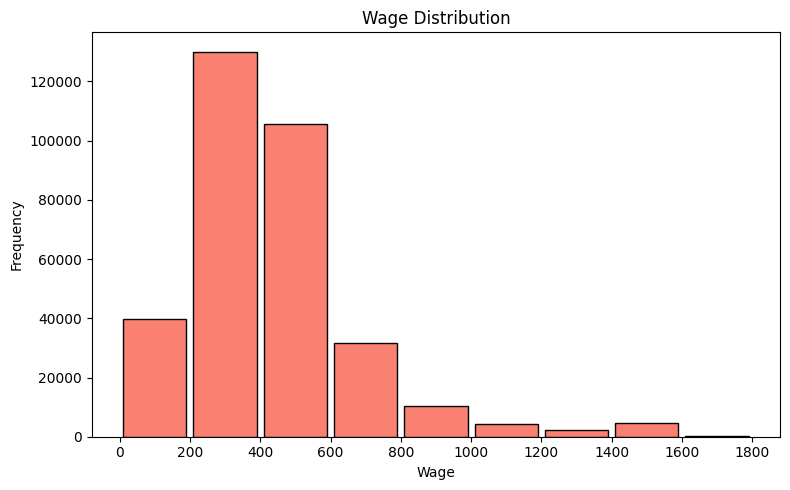

<Figure size 640x480 with 0 Axes>

In [4]:
# Age distribution: bins for each value from 51 to 60
age_bins = list(range(51, 62))  

plt.figure(figsize=(8, 5))
plt.hist(df['age'].to_numpy(), bins=age_bins, color='skyblue', edgecolor='black', rwidth=0.9)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(age_bins, age_bins, ha='center')
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.show()
plt.clf()

# Wage distribution: bins for every 200 interval from 0 to 2000, plus an extra bin for >2000
wage_bins = list(range(0, 2000, 200))

plt.figure(figsize=(8, 5))
plt.hist(df['wage'].to_numpy(), bins=wage_bins, color='salmon', edgecolor='black', rwidth=0.9)
plt.title('Wage Distribution')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.xticks(wage_bins)
plt.tight_layout()
plt.savefig('wage_distribution.png')
plt.show()
plt.clf()


In [ ]:
import statsmodels.api as sm

# Prepare the data for regression
X = df['educ'].to_numpy()
y = df['wage'].to_numpy()

X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Get robust standard errors
robust_results = model.get_robustcov_results(cov_type='HC0')

# Create formatted table matching the image
import pandas as pd

# Create the regression table
results_table = pd.DataFrame({
    '': ['(Intercept)', 'educ', 'Num. obs.', 'R$^{2}$', 'Adj. R$^{2}$'],
    'Homoskedastic': [
        f"{model.params[0]:.4f}***",
        f"{model.params[1]:.4f}***", 
        str(int(model.nobs)),
        f"{model.rsquared:.4f}",
        f"{model.rsquared_adj:.4f}"
    ],
    'White-Robust': [
        f"{model.params[0]:.4f}***",
        f"{model.params[1]:.4f}***",
        str(int(model.nobs)), 
        f"{model.rsquared:.4f}",
        f"{model.rsquared_adj:.4f}"
    ]
})

# Add standard errors in parentheses below coefficients
se_row_homo = pd.DataFrame({
    '': ['', ''],
    'Homoskedastic': [f"({model.bse[0]:.4f})", f"({model.bse[1]:.4f})"],
    'White-Robust': [f"({robust_results.bse[0]:.4f})", f"({robust_results.bse[1]:.4f})"]
})

# Insert standard error rows
final_table = pd.concat([
    results_table.iloc[:1],  # Intercept coefficient
    se_row_homo.iloc[:1],    # Intercept SE
    results_table.iloc[1:2], # educ coefficient  
    se_row_homo.iloc[1:2],   # educ SE
    results_table.iloc[2:]   # Stats rows
], ignore_index=True)

print(final_table.to_string(index=False))

# Save as LaTeX table
with open("simple_table.tex", "w") as f:
    f.write(final_table.to_latex(index=False, escape=False))

print("\nTable saved as 'simple_table.tex'")

             Homoskedastic White-Robust
 (Intercept)    61.1954***   61.1954***
                  (2.4623)     (2.5964)
        educ    29.6224***   29.6224***
                  (0.1868)     (0.2102)
   Num. obs.        329509       329509
     R$^{2}$        0.0709       0.0709
Adj. R$^{2}$        0.0709       0.0709

Table saved as 'simple_table.tex'


    Years of Education   Count  Average Squared Residuals  Standard Error
0                    0     598               88895.560800    13498.253264
1                    1     215               59502.685112    11836.994978
2                    2     606               40439.331867     4169.467476
3                    3    1089              158982.231738   118537.324419
4                    4    1345               66145.261920    11153.508044
5                    5    2003               70214.935493    22064.776091
6                    6    3874               62220.739373    15364.208469
7                    7    6177              194009.354061   107168.673523
8                    8   16118               69452.758846    12627.343837
9                    9   13183              104458.469334    25766.687702
10                  10   16530              141395.127675    48031.987769
11                  11   13674              104448.782980    27260.449733
12                  12  122934        

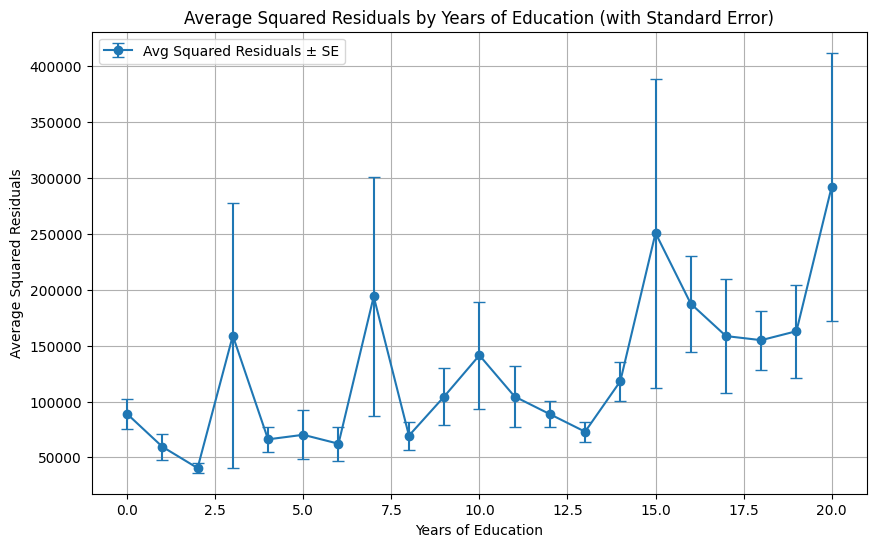

In [ ]:
import numpy as np
import pandas as pd

residuals = model.resid
residuals_2 = [res**2 for res in residuals]

# Get unique years of education (as integers)
educ_years = np.unique(df['educ'].to_numpy().astype(int))

avg_sq_residuals = []
stderr_sq_residuals = []

educ_col = df['educ'].to_numpy().astype(int)
residuals_arr = np.array(residuals)

for year in educ_years:
    mask = educ_col == year
    sq_res = residuals_arr[mask] ** 2
    avg_sq_residuals.append(sq_res.mean())
    stderr_sq_residuals.append(sq_res.std(ddof=1) / np.sqrt(len(sq_res)))

counts = [np.sum(educ_col == year) for year in educ_years]

table = pd.DataFrame({
    "Years of Education": educ_years,
    "Count": counts,
    "Average Squared Residuals": avg_sq_residuals,
    "Standard Error": stderr_sq_residuals
    
})

print(table)

plt.figure(figsize=(10, 6))
plt.errorbar(table["Years of Education"], table["Average Squared Residuals"], 
             yerr=table["Standard Error"], fmt='o-', capsize=4, label='Avg Squared Residuals ± SE')
plt.xlabel("Years of Education")
plt.ylabel("Average Squared Residuals")
plt.title("Average Squared Residuals by Years of Education (with Standard Error)")
plt.legend()
plt.grid(True)
plt.savefig('avg_squared_residuals.png')
plt.show()

In [ ]:
pop_coefficient = model.params[1]
print("Population coefficient for educ:", pop_coefficient)

sample_sizes = [20, 200, 2000]

for sample_size in sample_sizes:

    print(f"\nSample Size: {sample_size}")    

    num_samples = 10000
    num_intervals_containing_pop_coef = 0
    num_robust_intervals_containing_pop_coef = 0

    for i in range(num_samples):
        sample_df = df.sample(n=sample_size, with_replacement=False)

        # Prepare X and y for the sample
        X_sample = sample_df['educ'].to_numpy()
        y_sample = sample_df['wage'].to_numpy()

        # Add constant for intercept
        X_sample = sm.add_constant(X_sample)

        # Fit OLS regression on the sample
        sample_model = sm.OLS(y_sample, X_sample).fit()

        # Calculate 95% confidence interval for the educ coefficient
        coef = sample_model.params[1]
        
        # Classical (homoskedastic) standard error
        se = sample_model.bse[1]
        ci_lower = coef - 1.96 * se
        ci_upper = coef + 1.96 * se

        # Robust (heteroskedasticity-consistent) standard error
        robust_se = sample_model.get_robustcov_results(cov_type='HC0').bse[1]
        robust_ci_lower = coef - 1.96 * robust_se
        robust_ci_upper = coef + 1.96 * robust_se

        # Check if population coefficient is in each interval
        if ci_lower <= pop_coefficient <= ci_upper:
            num_intervals_containing_pop_coef += 1

        if robust_ci_lower <= pop_coefficient <= robust_ci_upper:
            num_robust_intervals_containing_pop_coef += 1



    coverage_probability = num_intervals_containing_pop_coef / num_samples
    print(f"Coverage Probability: {coverage_probability:.5f}")

    robust_coverage_probability = num_robust_intervals_containing_pop_coef / num_samples
    print(f"Robust Coverage Probability: {robust_coverage_probability:.5f}")



Population coefficient for educ: 29.622405418546208

Sample Size: 20
Coverage Probability: 0.88270
Robust Coverage Probability: 0.87240

Sample Size: 200
Coverage Probability: 0.90670
Robust Coverage Probability: 0.94160

Sample Size: 2000
Coverage Probability: 0.91830
Robust Coverage Probability: 0.95530
